In [1]:
import pennylane as qml

from pennylane import numpy as np
from pennylane.templates import RandomLayers

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import time

from itertools import product

In [2]:
# Hyper-parameters

N = 1

n_epochs = 30     # Number of optimization epochs
n_layers = 1      # Number of random layers
n_train = 5 * N   # Size of the train dataset
n_test = 3 * N    # Size of the test dataset

# n_epochs = 30   # Number of optimization epochs
# n_layers = 1    # Number of random layers
# n_train = 5    # Size of the train dataset
# n_test = 3     # Size of the test dataset


# Kernel

image_width = 28
image_length = 28

kernel_width = 2
kernel_length = 2

n_channels = n_qubits = kernel_width * kernel_length

qubits = list(range(n_qubits))

feature_width = image_width // kernel_width
feature_length = image_length // kernel_length


# Other parameters

SAVE_PATH = "data/"     # Data saving folder
PREPROCESS = True       # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)       # Seed for NumPy random number generator
tf.random.set_seed(0)   # Seed for TensorFlow random number generator

In [3]:
# Start time

start_time = time.time()


# Load MNIST dataset

mnist_dataset = keras.datasets.mnist
train_data, test_data = mnist_dataset.load_data()

full_train_images, full_train_labels = train_data
full_test_images, full_test_labels = test_data

# Reduced dataset

train_images = full_train_images[:n_train]
train_labels = full_train_labels[:n_train]

test_images = full_test_images[:n_test]
test_labels = full_test_labels[:n_test]

# Normalize pixel values within 0 and 1

train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels

train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [4]:
qml_device = qml.device("default.qubit", wires=n_qubits)

random_layer_parameters = np.random.uniform(high=2 * np.pi,
                                            size=(n_layers, n_channels))

In [5]:
# Quantum convolution kernel circuit

@qml.qnode(qml_device)
def kernel_circuit(pixel_values):    
  
    for qubit, pixel_value in enumerate(pixel_values):      
        
        theta = np.pi * pixel_value        
        qml.RY(theta, wires=qubit)        
   
    RandomLayers(random_layer_parameters, wires=qubits)
    
    measurement_result = [qml.expval(qml.PauliZ(qubit)) for qubit in qubits]

    return measurement_result

In [11]:
# Quanvolution

def quanvolve(image):
    
    """Convolve input image with many applications of the same quantum kernel circuit."""
    
    # Initialize
    
    features = np.zeros((feature_width, feature_length, n_channels))
    
    deltas = list(product(range(kernel_width),
                          range(kernel_length)))
    
    # Loop over image
    
    for corner_x in range(0, image_width, kernel_width):
        for corner_y in range(0, image_length, kernel_length):            
           
            pixel_values = []
            
            for x_delta, y_delta in deltas:
                
                x = corner_x + x_delta
                y = corner_y + y_delta
                
                pixel_values.append(np.squeeze(image[x, y]))
                
            # Call kernel
    
            kernel_outputs = kernel_circuit(pixel_values)
        
            # Feature outputs
        
            feature_corner_x = corner_x // kernel_width
            feature_corner_y = corner_y // kernel_length
            
            for channel, kernel_output in enumerate(kernel_outputs):
                
                features[feature_corner_x,
                         feature_corner_y,
                         channel] = kernel_output 

    # print("features:", features)
    print("features.shape:", features.shape)
    
    return features

In [12]:
# Quantum pre-processing of the dataset

if PREPROCESS == True:   
    
   
    print("Quantum pre-processing of train images:")

    q_train_images = []
    
    for image_index, image in enumerate(train_images):
        
        print(f"{image_index + 1}/{n_train} ", end="\r")
        
        q_train_images.append(quanvolve(image))
        
    q_train_images = np.asarray(q_train_images)

    
    
    print("\nQuantum pre-processing of test images:")

    q_test_images = []
    
    for image_index, image in enumerate(test_images):
        
        print(f"{image_index + 1}/{n_test}  ", end="\r")
        
        q_test_images.append(quanvolve(image))
        
    q_test_images = np.asarray(q_test_images)
    

    # Save pre-processed images
    
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images

q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
features.shape: (14, 14, 4)
features.shape: (14, 14, 4)
features.shape: (14, 14, 4)
features.shape: (14, 14, 4)
features.shape: (14, 14, 4)

Quantum pre-processing of test images:
features.shape: (14, 14, 4)
features.shape: (14, 14, 4)
features.shape: (14, 14, 4)


FileNotFoundError: [Errno 2] No such file or directory: 'data/q_train_images.npy'

In [ ]:
# Plot samples

n_samples = 5

figure, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))


# Input row

input_row = axes[0]

input_row[0].set_ylabel("Input")

for input_index, input_subplot in enumerate(input_row):
    
    input_subplot.imshow(train_images[input_index, :, :, 0], 
                         cmap="gray")
    
    input_subplot.xaxis.set_visible(False)
    input_subplot.yaxis.set_visible(False)
    
input_row[0].yaxis.set_visible(True)
    

# Channel rows

channel_rows = axes[1 : n_channels + 1]

for channel_index, channel_row in enumerate(channel_rows):
 
    for sample_index, sample_subplot in enumerate(channel_row):
        
        sample_subplot.imshow(q_train_images[sample_index, :, :, channel_index], 
                              cmap="gray")
    
        sample_subplot.xaxis.set_visible(False)
        sample_subplot.yaxis.set_visible(False)

        
    channel_row[0].set_ylabel(f"Output channel {channel_index}")    
    channel_row[0].yaxis.set_visible(True)    
    
for last_row_sample_subplot in channel_rows[-1]:
    last_row_sample_subplot.xaxis.set_visible(True)

        
plt.tight_layout()
plt.show()

In [9]:
# Hybrid quantum-classical model class

def MyModel():

    model = keras.models.Sequential([        
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")        
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    return model

In [10]:
# Hybrid quantum-classical model

q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=0,
)

final_q_loss = q_history.history['loss'][-1]
final_q_accuracy = q_history.history['accuracy'][-1]
final_q_validation_loss = q_history.history['val_loss'][-1]
final_q_validation_accuracy = q_history.history['val_accuracy'][-1]

print(f"Quantum-classical model:")
print(f"  Final loss: {final_q_loss:.2f}")
print(f"  Final accuracy: {final_q_accuracy:.2f}")
print(f"  Final validation loss: {final_q_validation_loss:.2f}")
print(f"  Final validation accuracy: {final_q_validation_accuracy:.2f}")

Quantum-classical model:
  Final loss: 0.05
  Final accuracy: 1.00
  Final validation loss: 6.96
  Final validation accuracy: 0.33


In [11]:
# Classical model

c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=0,
)

final_c_loss = c_history.history['loss'][-1]
final_c_accuracy = c_history.history['accuracy'][-1]
final_c_validation_loss = c_history.history['val_loss'][-1]
final_c_validation_accuracy = c_history.history['val_accuracy'][-1]

print(f"Classical model:")
print(f"  Final loss: {final_c_loss:.2f}")
print(f"  Final accuracy: {final_c_accuracy:.2f}")
print(f"  Final validation loss: {final_c_validation_loss:.2f}")
print(f"  Final validation accuracy: {final_c_validation_accuracy:.2f}")

Classical model:
  Final loss: 0.18
  Final accuracy: 1.00
  Final validation loss: 2.90
  Final validation accuracy: 0.33


In [12]:
q_history.history["val_accuracy"]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333432674408,
 0.3333333432674408,
 0.3333333432674408,
 0.3333333432674408,
 0.3333333432674408,
 0.3333333432674408,
 0.3333333432674408,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333432674408,
 0.3333333432674408,
 0.3333333432674408,
 0.3333333432674408,
 0.3333333432674408,
 0.3333333432674408]

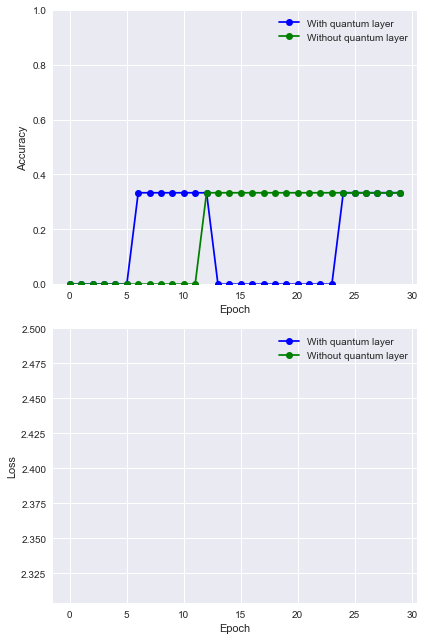

In [18]:
# Results

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.show()

In [13]:
execution_time = time.time() - start_time

print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 13.73 seconds


In [7]:
# Benchmark

factors = [1, 2, 4, 7, 14]

# factors = [1, 2]


# Parameters

parameter_list = []

for kernel_width in factors:
    
    for kernel_length in factors:
        
        kernel_surface = kernel_width * kernel_length
        
        parameters = {"kernel_width": kernel_width, 
                      "kernel_length": kernel_length,
                      "kernel_surface": kernel_surface}
        
        parameter_list.append(parameters)

sorted_parameters = sorted(parameter_list, 
                           key=lambda parameters: parameters['kernel_surface'])


# Quanvolution

for iteration, parameters in enumerate(sorted_parameters, 1):
    
    start_time = time.time()
    
    kernel_width = parameters['kernel_width']
    kernel_length = parameters['kernel_length']
    kernel_surface = parameters['kernel_surface']
    
    n_channels = n_qubits = kernel_width * kernel_length

    qubits = list(range(n_qubits))

    feature_width = image_width // kernel_width
    feature_length = image_length // kernel_length
    
    # QML device
    
    qml_device = qml.device("default.qubit", wires=n_qubits)

    random_layer_parameters = np.random.uniform(high=2 * np.pi,
                                                size=(n_layers, n_channels))
    
    # Quantum convolution kernel circuit

    @qml.qnode(qml_device)
    def kernel_circuit(pixel_values):    

        for qubit, pixel_value in enumerate(pixel_values):      

            theta = np.pi * pixel_value        
            qml.RY(theta, wires=qubit)        

        RandomLayers(random_layer_parameters, wires=qubits)

        measurement_result = [qml.expval(qml.PauliZ(qubit)) for qubit in qubits]

        return measurement_result

    # Printout
    
    print(f"")
    print(f"Iteration: {iteration}")
    print(f"")
    print(f"Quanvolution with kernel:")
    print(f"  Width: {kernel_width}")
    print(f"  Length: {kernel_length}")
    print(f"  Surface: {kernel_surface}")
    
    print("\nQuantum pre-processing of image...")
    
    image = train_images[0]
    
    quanvolve(image)
    
    # Time
    
    execution_time = time.time() - start_time

    print(f"Execution time: {execution_time:.2f} seconds")

MemoryError: Unable to allocate 8.00 PiB for an array with shape (562949953421312,) and data type complex128

In [37]:
test_value = 1

def test():
    
    print("Test value:", test_value)
    
test()

test_value = 20

test()

Test value: 1
Test value: 20
